In [1]:
import numpy as np
from point_history import getmes
import pickle
import datetime
from get_point_map import get
from get_point_history import pget
from netCDF4 import Dataset
import pandas as pd
from ipywidgets import interact
import matplotlib.pyplot as plt

In [2]:
import os

In [3]:
import folium

In [4]:
import verif

In [5]:
import itertools

In [6]:
from pandas.compat import u

In [7]:
%matplotlib notebook

In [8]:
SAVEPATH='tmp/'

In [9]:
path='/mnt/rmdisk/hincast/'

In [10]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [11]:
basename='med'

In [12]:
t1='20131201.00'

In [13]:
t2='20140228.12'

In [14]:
sdate=datetime.datetime.strptime(t1,'%Y%m%d.%H')

In [15]:
edate=datetime.datetime.strptime(t2,'%Y%m%d.%H')

In [16]:
path0=path+'{}/{}/{}/{:02d}/'.format(sdate.year,sdate.month,sdate.day,sdate.hour)

In [17]:
with open(path0+basename+'.pkl', 'r') as f:
    ptr=pickle.load(f)

In [18]:
iloc=1843 # CHANGE THIS FOR ANALYSIS OF ANOTHER OBS POINT

In [19]:
t,s,plat,plon,bname,bid = getmes(sdate,edate,iloc) # measured data
dic0={'t_gauge':t, 'sh':[a for [a,b,c] in s], 'tide':[b for [a,b,c] in s], 'ss':[c for [a,b,c] in s]}
data0=pd.DataFrame(dic0)
data0=data0.set_index('t_gauge')


In [20]:
tcw,cw,mlat,mlon,jc,ic=get(t1,t2,path,basename,plat,plon) # map interpolated data
dic1={'t_map':tcw, 's_map':cw}
data1=pd.DataFrame.from_dict(dic1)
data1=data1.set_index('t_map')
data=data0.join(data1, how='outer')

In [21]:
hcw,hw,hlat,hlon=pget(t1,t2,path,basename,ptr[iloc]) # obs point 1 min sampling 
dic2={'t_his':hcw, 's_his':hw}
data2=pd.DataFrame.from_dict(dic2)
data2=data2.set_index('t_his')
data=data.join(data2, how='outer')

In [22]:
#check that the 'returned' iDs are the same as the read ones
np.int(bid) == iloc

True

In [23]:
data.head()

,sh,ss,tide,s_map,s_his
2013-12-01 00:00:00,NaN,NaN,NaN,-0.007757,-0.008501
2013-12-01 00:01:00,NaN,NaN,NaN,NaN,-0.010010
2013-12-01 00:02:00,NaN,NaN,NaN,NaN,-0.011808
2013-12-01 00:03:00,NaN,NaN,NaN,NaN,-0.013599
2013-12-01 00:04:00,NaN,NaN,NaN,NaN,-0.015156


### read grid 

In [24]:
d=Dataset(path0+'trim-'+basename+'.nc')

In [25]:
xg=d['XCOR'][:]
yg=d['YCOR'][:]

In [26]:
xz=d['XZ'][:]
yz=d['YZ'][:]

In [27]:
mapa = folium.Map(location=[plat, plon], zoom_start=12)

In [28]:
folium.Marker([plat,plon], popup=bname).add_to(mapa)

In [29]:
folium.CircleMarker([yz[ic,jc],xz[ic,jc]], popup='{},{}/{},{}'.format(mlat,mlon,jc,ic)).add_to(mapa)

In [30]:
folium.CircleMarker([mlat,mlon], popup='{},{}'.format(mlat,mlon),fill_color='blue').add_to(mapa)

In [31]:
folium.CircleMarker([hlat,hlon], popup='{},{}'.format(hlat,hlon),fill_color='green').add_to(mapa)

In [32]:
a=np.arange(-5,5)
b=np.arange(-5,5)
glist=[]
for r in itertools.product(a,b): glist.append((r[0],r[1]))
#glist

In [33]:
for k,l in glist:
    try:
        m1=ic+k
        m2=jc+l
        xgrid=zip(yg[m1,m2-5:m2+5],xg[m1,m2-5:m2+5])
        ygrid=zip(yg[m1-5:m1+5,m2],xg[m1-5:m1+5,m2])
        folium.PolyLine(xgrid,weight=1, color='black').add_to(mapa)
        folium.PolyLine(ygrid,weight=1, color='black').add_to(mapa)
        folium.CircleMarker([yg[m1,m2],xg[m1,m2]], popup='{},{}'.format(m1,m2), radius=50).add_to(mapa)
        folium.CircleMarker([yz[m1,m2],xz[m1,m2]], popup='{},{}'.format(m1,m2), radius=50, fill_color='red').add_to(mapa)
    except Exception as e:
        print e
        pass

In [34]:
folium.LatLngPopup().add_to(mapa) # click to show lat lon

In [35]:
mapa

<IPython.core.display.Javascript object>


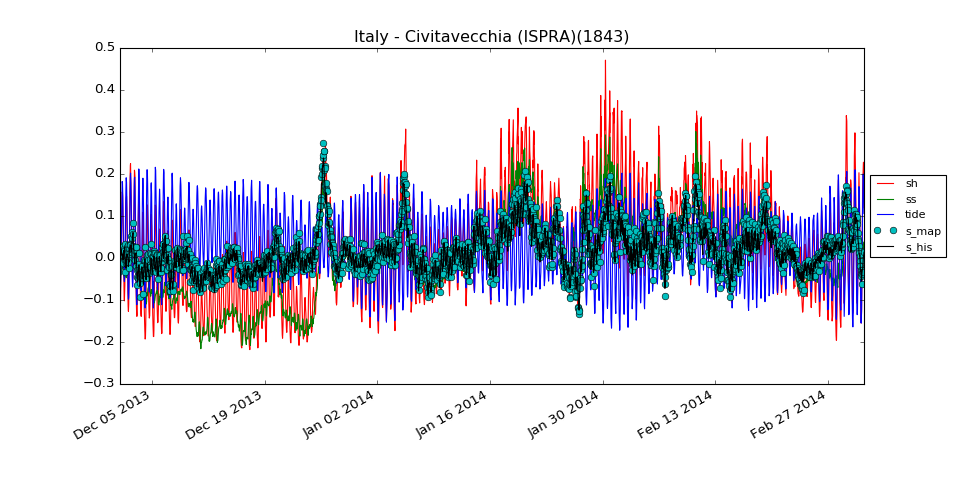

In [33]:
ax=data[['sh','ss','tide']].dropna().apply(pd.to_numeric).plot(figsize=(12,6),style=['r-','g-','b-'])
data[['s_map','s_his']].dropna().apply(pd.to_numeric).plot(ax=ax, style=['co','k-'])
ax.legend(loc='center left', bbox_to_anchor=(1.,.5), prop={'size':10})
ax.set_title(bname+'('+bid+')')

## Analysis

## check variance

In [36]:
obs = data['ss'].dropna().apply(pd.to_numeric)

In [37]:
num = data['s_map'].dropna().apply(pd.to_numeric)

In [38]:
obs.std() # standart deviation of observation

0.099936494059916003

In [39]:
num.std() # standart deviation of numerical results

0.056382454849942171

In [61]:
#ratio
num.std()/obs.std()

0.56418283811455894

computer rolling mean every 60 points

In [41]:
ma = obs.rolling(60).mean()

In [42]:
mstd = obs.rolling(60).std() #standard deviation

<IPython.core.display.Javascript object>


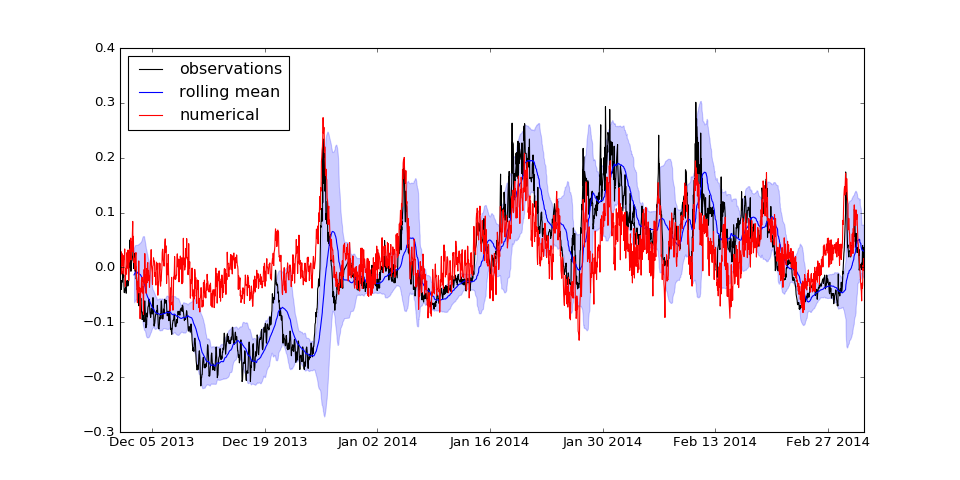

In [49]:
#plot them
plt.figure(figsize=(12,6))
plt.plot(obs.index, obs, 'k', label='observations')
plt.plot(ma.index, ma, 'b', label='rolling mean')
plt.plot(num.index, num, 'r', label='numerical')
plt.fill_between(mstd.index, ma-2*mstd, ma+2*mstd, color='b', alpha=0.2)
plt.legend(loc=0)

In [50]:
ma_num = num.rolling(60).mean()

In [51]:
mstd_num = num.rolling(60).std() #standard deviation

<IPython.core.display.Javascript object>


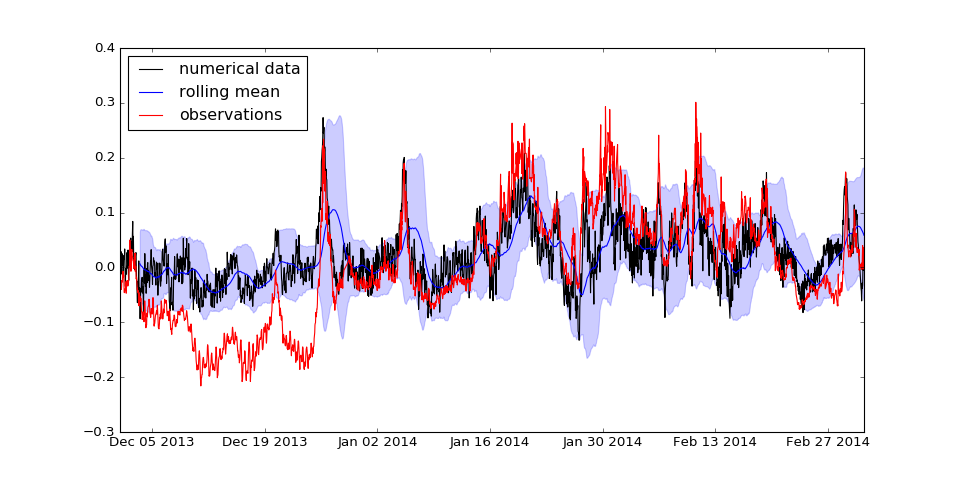

In [52]:
#plot them
plt.figure(figsize=(12,6))
plt.plot(num.index, num, 'k', label='numerical data')
plt.plot(ma_num.index, ma_num, 'b', label='rolling mean')
plt.plot(obs.index, obs, 'r', label='observations')
plt.fill_between(mstd_num.index, ma_num-2*mstd_num, ma_num+2*mstd_num, color='b', alpha=0.2)
plt.legend(loc=0)

## compute corellation between measured and computed

In [43]:
num.head()

2013-12-01 00:00:00   -0.007757
2013-12-01 01:00:00    0.014277
2013-12-01 02:00:00   -0.013821
2013-12-01 03:00:00    0.028839
2013-12-01 04:00:00    0.002514
Name: s_map, dtype: float64

In [44]:
obs.head()

2013-12-01 00:13:00   -0.033
2013-12-01 00:57:00   -0.038
2013-12-01 01:33:00   -0.039
2013-12-01 02:20:00   -0.029
2013-12-01 03:37:00   -0.039
Name: ss, dtype: float64

In [45]:
rnum=num.reindex(obs.index,method='pad')

In [46]:
rnum.corr(obs) #total correlation

0.69983225991007392

### Use verif

In [47]:
obs.head()

2013-12-01 00:13:00   -0.033
2013-12-01 00:57:00   -0.038
2013-12-01 01:33:00   -0.039
2013-12-01 02:20:00   -0.029
2013-12-01 03:37:00   -0.039
Name: ss, dtype: float64

In [48]:
s=obs.resample("1H").mean()

In [49]:
s.head()

2013-12-01 00:00:00   -0.0355
2013-12-01 01:00:00   -0.0390
2013-12-01 02:00:00   -0.0290
2013-12-01 03:00:00   -0.0390
2013-12-01 04:00:00   -0.0370
Freq: H, Name: ss, dtype: float64

In [50]:
## create dataframe for verif
dicv={'obs':s, 'fcst':num, 'offset': num.index.hour}
comp=pd.DataFrame.from_dict(dicv)
comp=comp.set_index(num.index).dropna() # drop NAN values
comp.head()

,fcst,obs,offset
2013-12-01 00:00:00,-0.007757,-0.0355,0
2013-12-01 01:00:00,0.014277,-0.0390,1
2013-12-01 02:00:00,-0.013821,-0.0290,2
2013-12-01 03:00:00,0.028839,-0.0390,3
2013-12-01 04:00:00,0.002514,-0.0370,4


<IPython.core.display.Javascript object>


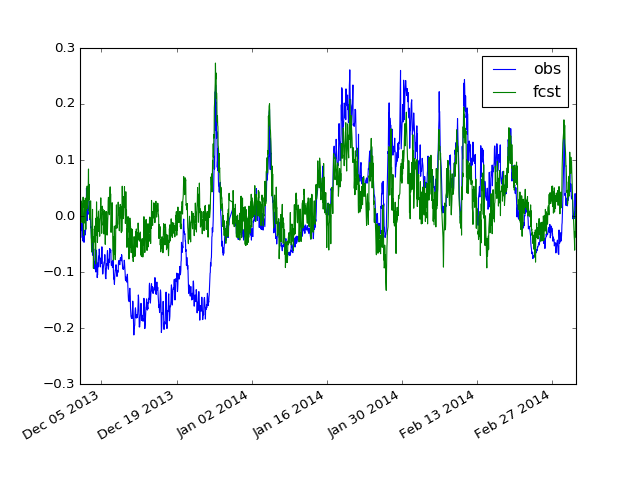

In [59]:
comp[['obs','fcst']].plot()

In [52]:
output=''.join(bname.split())

In [53]:
#save file
comp.to_csv(SAVEPATH+output+'verif.csv', sep=' ', date_format='%Y%m%d', index_label='date')

In [54]:
cwd = os.getcwd()

In [55]:
vpath= cwd +'/' + SAVEPATH+output+'verif.csv'

In [56]:
data=verif.Data.Data(vpath)

In [57]:
pl=verif.Output.Taylor()

<IPython.core.display.Javascript object>


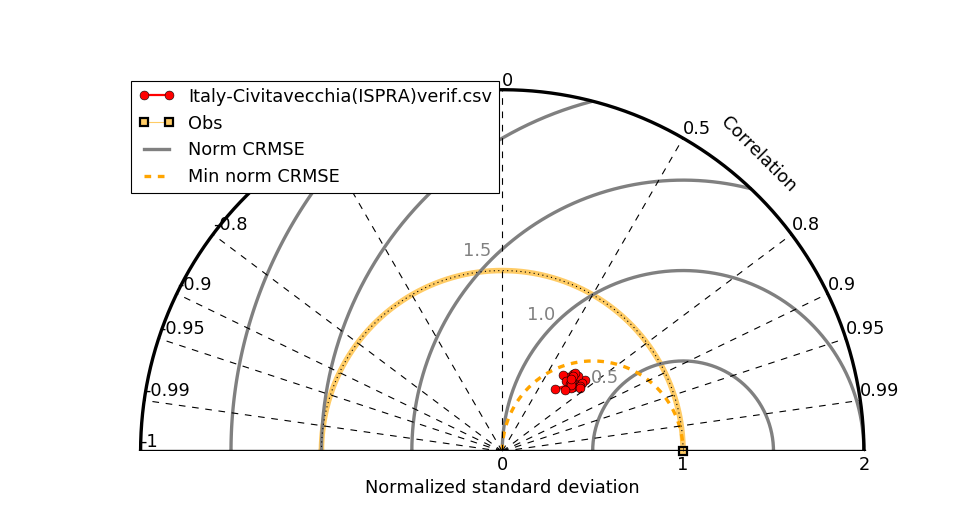

In [64]:
pl.plot(data)

## Get All forecasting data

In [57]:
dt=(edate-sdate).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1

In [58]:
combined=[] # store time and height
tstamp = [] # for use later

In [59]:
tot=[]

In [60]:
indx=pd.date_range(sdate, edate, freq='12H')

In [61]:
val=[]

In [62]:
for it in range(ndt):
    idate=sdate+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    path0=path+'{}/{}/{}/{:02d}/'.format(idate.year,idate.month,idate.day,idate.hour)
    filename=path0+'trim-'+basename+'.nc'
    d =  Dataset(filename)
    ha=d.variables['S1'][:,ic,jc] # all values
    t=d.variables['time'][:]
    tw=[]
    for it in t:
        tw.append(idate+datetime.timedelta(seconds=np.int(it)))
    ttw=[(item-t[0])/60. for item in t]
    dic={'time':tw, 'numerical storm surge':ha, 'forecast_time':ttw}
    val.append(ha)
    data=pd.DataFrame.from_dict(dic)
    data=data.set_index('time')
    tot.append(data)

In [63]:
tota=pd.concat(tot,keys=indx)

In [64]:
tota.head()

forecast_time  numerical storm surge
           time                                                     
2013-12-01 2013-12-01 00:00:00            0.0              -0.007757
           2013-12-01 01:00:00           60.0               0.014277
           2013-12-01 02:00:00          120.0              -0.013821
           2013-12-01 03:00:00          180.0               0.028839
           2013-12-01 04:00:00          240.0               0.002514

In [65]:
dat=tota.drop('forecast_time',1)

In [66]:
dat.head()

numerical storm surge
           time                                      
2013-12-01 2013-12-01 00:00:00              -0.007757
           2013-12-01 01:00:00               0.014277
           2013-12-01 02:00:00              -0.013821
           2013-12-01 03:00:00               0.028839
           2013-12-01 04:00:00               0.002514

## plot all forecasts

<IPython.core.display.Javascript object>


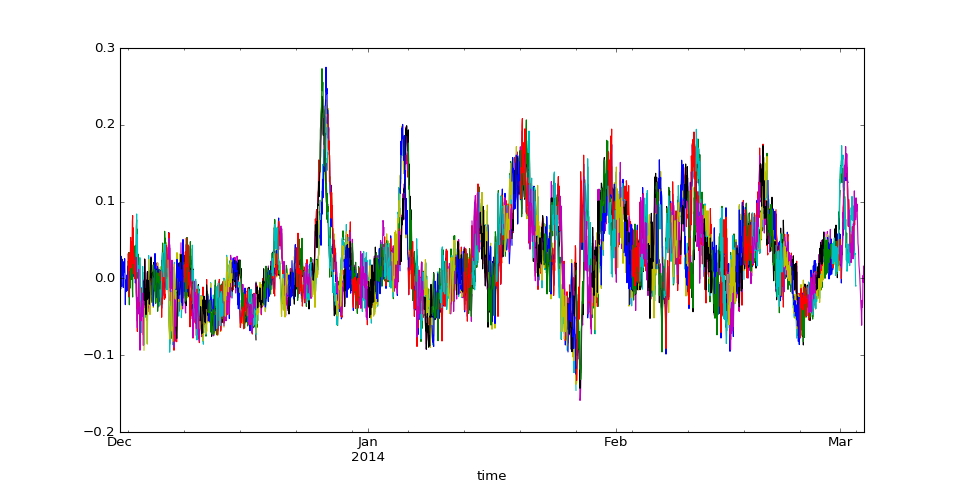

In [67]:
dat.unstack(level=0).plot(figsize=(12,6),legend=False)

In [614]:
## save the data
dat.to_csv(SAVEPATH+bname+'time_ref.csv', header=None)

## replace index

In [68]:
tota.head()

forecast_time  numerical storm surge
           time                                                     
2013-12-01 2013-12-01 00:00:00            0.0              -0.007757
           2013-12-01 01:00:00           60.0               0.014277
           2013-12-01 02:00:00          120.0              -0.013821
           2013-12-01 03:00:00          180.0               0.028839
           2013-12-01 04:00:00          240.0               0.002514

In [69]:
tota.drop('forecast_time',1, inplace=True)

In [70]:
tota.head()

numerical storm surge
           time                                      
2013-12-01 2013-12-01 00:00:00              -0.007757
           2013-12-01 01:00:00               0.014277
           2013-12-01 02:00:00              -0.013821
           2013-12-01 03:00:00               0.028839
           2013-12-01 04:00:00               0.002514

In [81]:
ht=np.array([np.arange(73) for i in range(tota.index.levels[0].shape[0])]).ravel() # 72 hours + 1 

In [82]:
index0=[(a, c) for (a,b),c in zip(tota.index.tolist(),ht)]

In [83]:
tota.index=pd.MultiIndex.from_tuples(index0,names=tota.index.names)

In [84]:
tota.head()

numerical storm surge
           time                       
2013-12-01 0                 -0.007757
           1                  0.014277
           2                 -0.013821
           3                  0.028839
           4                  0.002514

In [149]:
tota.unstack(level=0).head()

numerical storm surge                                          \
       2013-12-01 00:00:00 2013-12-01 12:00:00 2013-12-02 00:00:00   
time                                                                 
0                -0.007757            0.021955            0.031769   
1                 0.014277            0.015769           -0.010692   
2                -0.013821            0.033671           -0.023792   
3                 0.028839           -0.004743            0.024597   
4                 0.002514           -0.034397            0.010197   

                                                                  \
     2013-12-02 12:00:00 2013-12-03 00:00:00 2013-12-03 12:00:00   
time                                                               
0               0.028951            0.027076           -0.093501   
1               0.062031           -0.017944           -0.058844   
2               0.083912           -0.027702           -0.039252   
3               0.028623           -0.044529           -0.044612   
4               0.056653           -0.064309           -0.023052   

                                                                  \
     2013-12-04 00:00:00 2013-12-04 12:00:00 2013-12-05 00:00:00   
time                                                               
0              -0.003774           -0.024125           -0.009625   
1              -0.028456           -0.005344           -0.030844   
2               0.025166           -0.023016            0.002375   
3              -0.007711           -0.016025            0.003881   
4              -0.034955           -0.036139            0.017527   

                                 ...                              \
     2013-12-05 12:00:00         ...         2014-02-24 00:00:00   
time                             ...                               
0               0.003784         ...                   -0.027082   
1               0.009668         ...                   -0.077309   
2              -0.002416         ...                   -0.026962   
3               0.007540         ...                   -0.013028   
4              -0.015454         ...                   -0.038273   

                                                                  \
     2014-02-24 12:00:00 2014-02-25 00:00:00 2014-02-25 12:00:00   
time                                                               
0              -0.011026           -0.026175           -0.007876   
1              -0.020777           -0.021407           -0.007972   
2              -0.004615           -0.044718           -0.022493   
3              -0.025537           -0.033638           -0.013908   
4              -0.020530           -0.030737            0.001239   

                                                                  \
     2014-02-26 00:00:00 2014-02-26 12:00:00 2014-02-27 00:00:00   
time                                                               
0               0.004110            0.021637            0.037695   
1              -0.014896            0.041200            0.025920   
2              -0.014879            0.040454            0.053439   
3               0.000825            0.029345            0.000545   
4              -0.013104            0.024898            0.016758   

                                                                  
     2014-02-27 12:00:00 2014-02-28 00:00:00 2014-02-28 12:00:00  
time                                                              
0               0.018351            0.025984            0.041791  
1               0.041139            0.045245            0.024540  
2               0.013801            0.023539            0.019142  
3               0.013481            0.019008            0.042631  
4               0.036462            0.024744            0.014508  

[5 rows x 180 columns]

In [615]:
## save the data
s.to_csv(SAVEPATH+bname+'forecast.csv')